<a href="https://colab.research.google.com/github/AdrienVansuyt/Python-Quant-Exercices/blob/main/Hierarchical%20Equal%20Risk%20Contribution%20with%20Python%20and%20Riskfolio%20Lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HERC presents a novel approach to portfolio optimization devised by Thomas Raffinot (2018). This method addresses the limitations of
Hierarchical Risk Parity (HRP), which overlooked utilizing the clusters derived from hierarchical tree clustering during the asset allocation
process.

The HERC model comprises the following five steps:
Hierarchical Tree Clustering: Leveraging the interrelationships among financial assets, such as correlations, to construct a hierarchical
structure visualized as a dendrogram.

Determining the Optimal Number of Clusters: Identifying the optimal number of clusters based on the hierarchical structure established in
the initial step. While Raffinot originally proposed employing the Gap Index (Tibshirani 2001), due to computational constraints, RiskfolioLib adopts the Two Difference Gap Index (Yue, S., Wang, X. & Wei 2009).

Matrix Seriation: Arranging the assets within the dendrogram to minimize the distance between leaves.

Top-Down Recursive Division: Dividing the weights along the dendrogram into two segments using equal risk contribution allocation, from
the top of the tree down to the clusters. The outcome yields the weight assigned to each cluster.

Naive Risk Parity within Clusters: Utilizing naive risk parity, where weights are determined based on the inverse of each asset's risk, to
compute weights within clusters. These weights are then multiplied by the cluster weight.

In [1]:
pip install Riskfolio-Lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.6/307.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.4
    Uninstalling cvxpy-1.3.4:
      Successfully uninstalled cvxpy-1.3.4


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
from riskfolio import PlotFunctions
warnings.filterwarnings("ignore")
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format
# Date range
start = '2016-01-01'
end = '2024-12-30'
# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


In [4]:
# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
# Calculating returns
Y = data[assets].pct_change().dropna()

[*********************100%%**********************]  25 of 25 completed


In [5]:
display(Y.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-2.0257%,0.4057%,0.4036%,1.9693%,0.0180%,0.9305%,0.3678%,0.5783%,0.9483%,-1.1954%,...,1.5881%,0.0212%,2.8236%,0.9758%,0.6987%,1.7539%,-0.1729%,0.2409%,1.3735%,-1.0857%
2016-01-06,-11.4863%,-1.5879%,0.2412%,-1.7557%,-0.7727%,-1.2473%,-0.1736%,-1.1239%,-3.5867%,-0.9551%,...,0.5547%,0.0212%,0.1592%,-1.5647%,0.3108%,-1.0155%,-0.7654%,-3.0048%,-0.9035%,-2.9145%
2016-01-07,-5.1389%,-4.1922%,-1.6573%,-2.7699%,-1.1047%,-1.9769%,-1.2206%,-0.8855%,-4.6059%,-2.5394%,...,-2.2066%,-3.0310%,-1.0410%,-3.1557%,-1.6148%,-0.2700%,-2.2844%,-2.0570%,-0.5492%,-3.0019%
2016-01-08,0.2736%,-2.2705%,-1.6037%,-2.5425%,0.1099%,-0.2241%,0.5706%,-1.6402%,-1.7642%,-0.1649%,...,-0.1538%,-1.1366%,-0.7308%,-0.1448%,0.0895%,-3.3839%,-0.1116%,-1.1387%,-0.9720%,-1.1254%
2016-01-11,-4.3383%,0.1693%,-1.6851%,-1.0216%,0.0914%,-1.1791%,0.5674%,0.5287%,0.6617%,0.0331%,...,1.6435%,0.0000%,0.9870%,-0.1450%,1.2224%,1.4570%,0.5366%,-0.4607%,0.5800%,-1.9919%


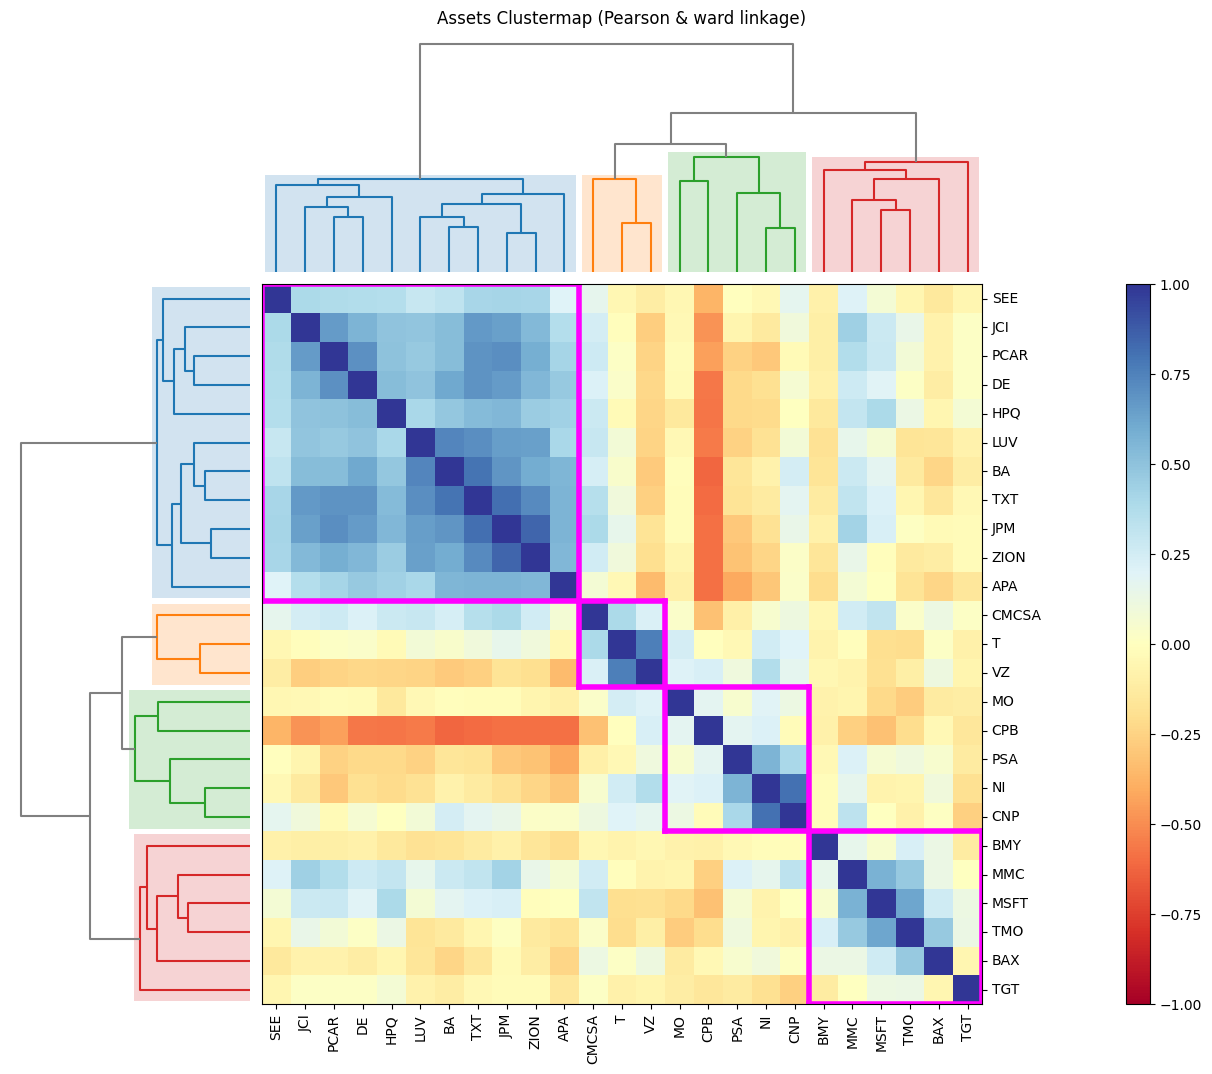

In [11]:
# Calculating correlation matrix
corr_matrix = Y.corr()
# Plotting Assets Clusters
ax = PlotFunctions.plot_clusters(returns=corr_matrix,
linkage='ward',
k=None,
max_k=10,
leaf_order=True,
dendrogram=True,
#linecolor='tab:purple',
ax=None)

In [8]:
from riskfolio import HCPortfolio
# Building the portfolio object
port = HCPortfolio(returns=Y)
# Estimate optimal portfolio:
model='HERC' # Could be HRP or HERC
correlation = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram
w = port.optimization(model=model,
correlation=correlation,
rm=rm,
rf=rf,
linkage=linkage,
max_k=max_k,
leaf_order=leaf_order)
display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,2.2212%,4.5186%,1.1613%,1.3070%,0.4972%,1.7084%,0.8158%,8.7461%,6.8183%,10.7201%,...,2.1902%,12.2785%,2.2749%,7.8764%,0.5920%,1.9293%,1.1795%,6.9347%,0.8484%,4.9795%


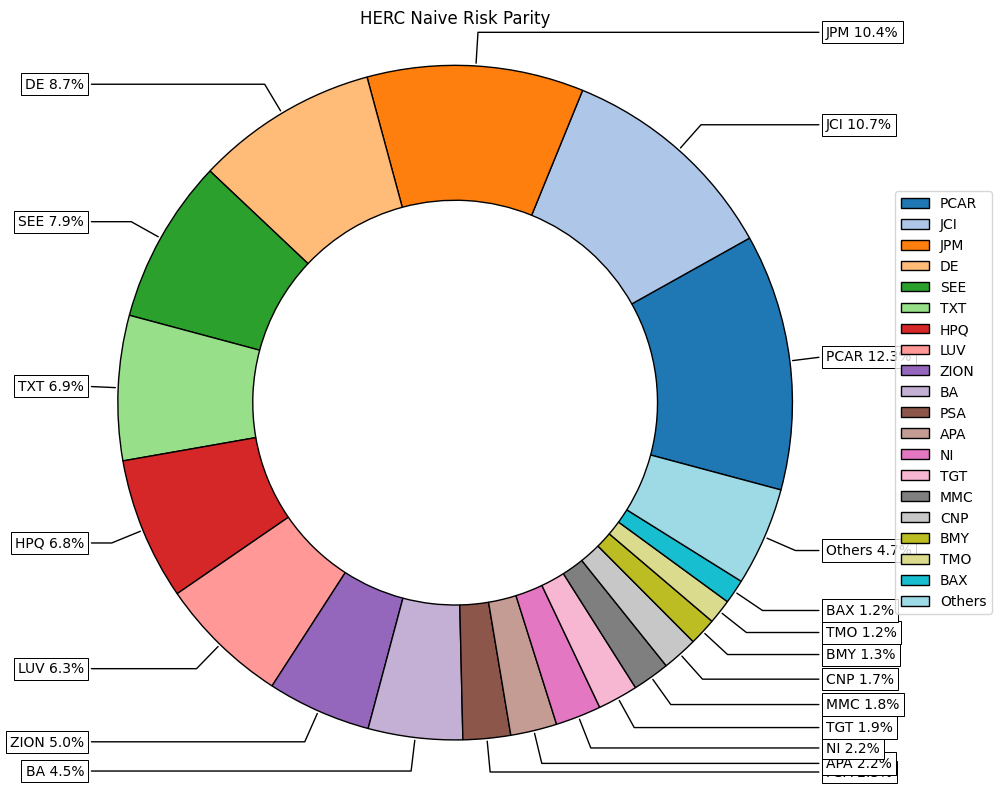

In [12]:
#As you can see, we get the optimal portfolio based on HERC in few steps. If we want to see the structure of the portfolio, we can plot a pie chart:

from riskfolio import PlotFunctions as plf
# Plotting the composition of the portfolio
ax = plf.plot_pie(w=w,
title='HERC Naive Risk Parity',
others=0.05,
nrow=25,
cmap="tab20",
height=8,
width=10,
ax=None)

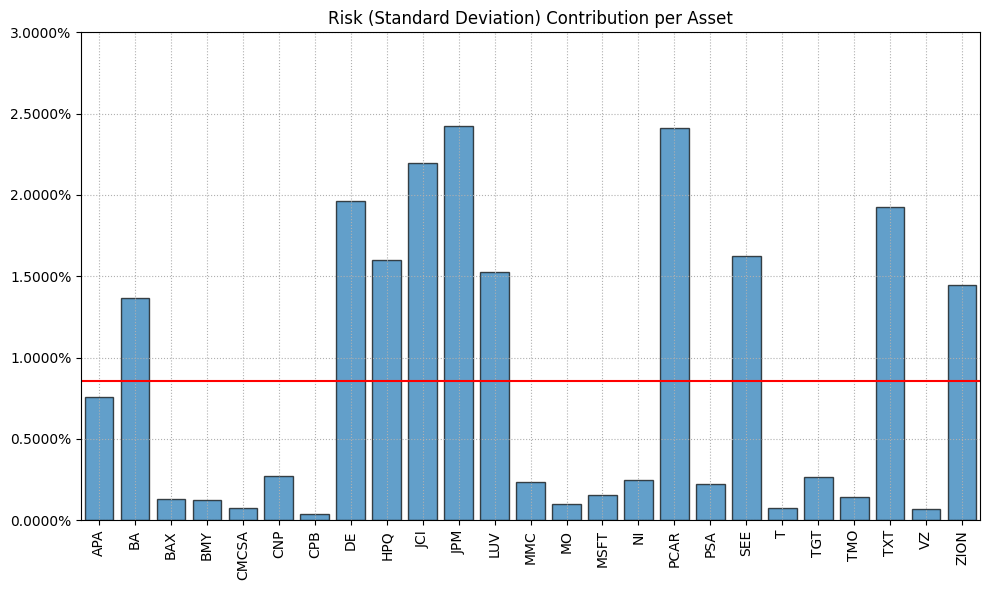

In [13]:
# Plotting the risk contribution per asset
mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets
ax = plf.plot_risk_con(w=w,
cov=cov,
returns=returns,
rm=rm,
rf=0,
alpha=0.05,
color="tab:blue",
height=6,
width=10,
t_factor=252,
ax=None)

One thing that we notice when we see the plot above and the heatmap, it is that the HERC model can’t make that the risk contribution of
each asset within clusters be equal, for example BAX and BMY are in the same cluster but they have different level of risk contribution.
The property of equal risk contribution per cluster can be reached using a vanilla risk parity model. Until now, we have working using
variance as risk measure, however Riskfolio-Lib has 22 risk measures available for portfolios based on the hierarchical relationship
among assets, to compare asset allocation based on the 22 risk measures using HERC, we must run the following code:

In [17]:
# Risk Measures available:
#
# 'vol': Standard Deviation.
# 'MV': Variance.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'VaR': Conditional Value at Risk.
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'DaR': Drawdown at Risk of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
# 'MDD_Rel': Maximum Drawdown of compounded cumulative returns (Calmar Ratio).
# 'ADD_Rel': Average Drawdown of compounded cumulative returns.
# 'DaR_Rel': Drawdown at Risk of compounded cumulative returns.
# 'CDaR_Rel': Conditional Drawdown at Risk of compounded cumulative returns.
# 'EDaR_Rel': Entropic Drawdown at Risk of compounded cumulative returns.
# 'UCI_Rel': Ulcer Index of compounded cumulative returns.
#
rms = ['vol', 'MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
'VaR','CVaR', 'EVaR', 'WR', 'MDD', 'ADD',
'DaR', 'CDaR', 'EDaR', 'UCI', 'MDD_Rel', 'ADD_Rel',
'DaR_Rel', 'CDaR_Rel', 'EDaR_Rel', 'UCI_Rel']
w_s = pd.DataFrame([])
for i in rms:
  w = port.optimization(model=model,
  correlation=correlation,
  rm=i,
  rf=rf,
  linkage=linkage,
  max_k=max_k,
  leaf_order=leaf_order)
  w_s = pd.concat([w_s, w], axis=1)
w_s.columns = rms
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,vol,MV,MAD,MSV,FLPM,SLPM,VaR,CVaR,EVaR,WR,MDD,ADD,DaR,CDaR,EDaR,UCI,MDD_Rel,ADD_Rel,DaR_Rel,CDaR_Rel,EDaR_Rel,UCI_Rel
APA,4.15%,2.22%,4.31%,4.12%,4.23%,4.08%,4.75%,4.46%,2.58%,2.30%,2.65%,3.25%,3.67%,3.32%,2.72%,3.39%,4.32%,2.76%,3.73%,3.85%,3.95%,3.19%
BA,5.92%,4.52%,6.37%,6.01%,6.30%,5.97%,6.17%,5.93%,5.40%,5.20%,3.88%,5.27%,5.05%,4.58%,4.24%,5.06%,5.19%,3.70%,4.46%,4.70%,4.85%,3.81%
BAX,1.21%,1.16%,1.25%,1.18%,1.20%,1.16%,1.20%,1.13%,1.04%,1.04%,0.78%,0.36%,0.34%,0.47%,0.60%,0.37%,0.94%,0.45%,0.46%,0.63%,0.76%,0.46%
BMY,1.29%,1.31%,1.30%,1.25%,1.24%,1.22%,1.35%,1.23%,0.93%,0.80%,1.16%,0.41%,0.61%,0.80%,0.96%,0.54%,1.27%,0.44%,0.73%,0.97%,1.10%,0.57%
CMCSA,0.45%,0.50%,0.42%,0.45%,0.41%,0.45%,0.41%,0.43%,0.62%,0.67%,0.32%,0.17%,0.18%,0.22%,0.27%,0.19%,0.39%,0.21%,0.23%,0.29%,0.32%,0.22%
CNP,1.65%,1.71%,1.77%,1.65%,1.75%,1.63%,1.79%,1.68%,1.18%,1.09%,1.07%,1.26%,1.20%,1.16%,1.10%,1.27%,1.20%,1.17%,1.04%,1.17%,1.21%,1.17%
CPB,0.70%,0.82%,0.65%,0.71%,0.62%,0.70%,0.71%,0.69%,0.93%,0.91%,0.75%,0.21%,0.33%,0.39%,0.51%,0.29%,0.73%,0.23%,0.38%,0.46%,0.54%,0.30%
DE,8.23%,8.75%,8.08%,8.20%,8.34%,8.31%,7.94%,8.20%,8.68%,8.81%,12.30%,14.53%,15.67%,14.12%,12.89%,14.47%,10.66%,14.84%,14.54%,12.76%,11.77%,14.44%
HPQ,7.27%,6.82%,7.41%,7.10%,7.53%,7.14%,7.08%,6.96%,7.12%,7.18%,9.70%,8.31%,9.44%,9.73%,9.90%,8.80%,8.45%,8.09%,9.15%,8.85%,8.69%,8.35%
JCI,9.11%,10.72%,8.70%,8.78%,8.76%,8.81%,8.71%,8.67%,9.55%,9.31%,9.05%,8.49%,8.32%,8.39%,8.75%,8.53%,8.72%,8.63%,8.62%,8.64%,8.73%,8.71%


<Axes: >

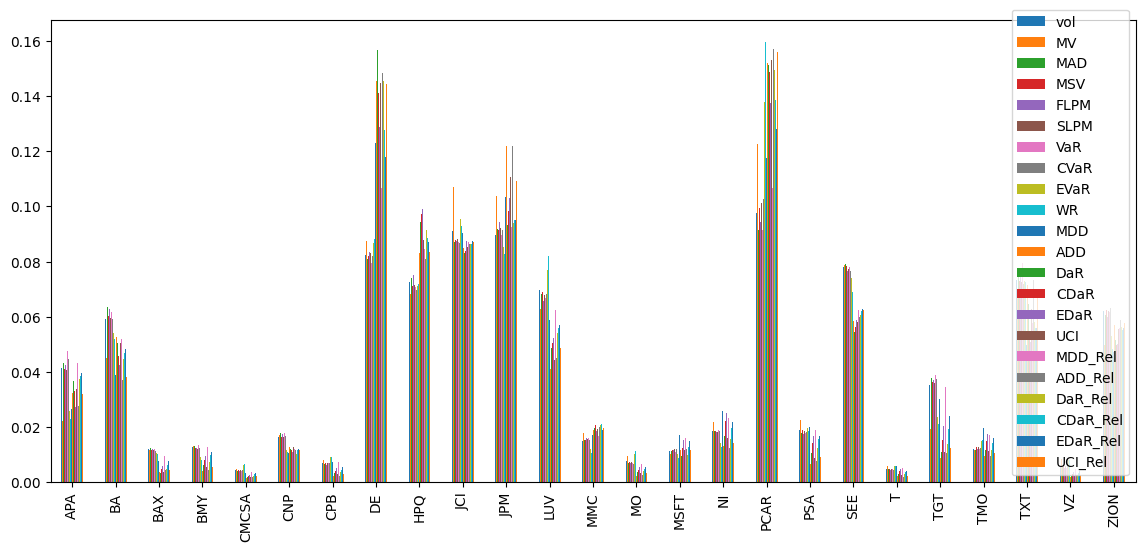

In [18]:
#We can made a bar plot comparing asset allocation of each risk measure:
import matplotlib.pyplot as plt
# Plotting a comparison of assets weights for each portfolio
fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)
w_s.plot.bar(ax=ax)